In [109]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.model_selection import train_test_split
import os, multiprocessing
from sklearn.metrics import mean_squared_error

In [110]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
mem_gib = mem_bytes / (1024.**3)
print("Computer characteristics: ")
print("RAM: %f GB" % mem_gib)
print("CORES: %d" % multiprocessing.cpu_count())


Computer characteristics: 
RAM: 7.653069 GB
CORES: 4


In [111]:
train = pd.read_csv('train.csv')
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [112]:
countries = train['Country_Region'].unique()
print("Number of different countries: ", len(countries))
print("\n")
min_date = train.Date.min()
max_date = train.Date.max()
print("Min date: {0}\nMax date: {1}".format(min_date, max_date))
print("\n")
print("Null values:") 
print(train.isnull().sum())

Number of different countries:  184


Min date: 2020-01-22
Max date: 2020-04-09


Null values:
Id                    0
Province_State    14220
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64


In [113]:
def fillState(state, country):
    if state == "empty":
        return country
    return state

train['Province_State'].fillna("empty", inplace = True)
train['Province_State'] = train.loc[:,['Province_State', 'Country_Region']].apply(lambda x: fillState(x['Province_State'], x['Country_Region']), axis = 1)


# renaming columns
train=train.rename(columns={'ConfirmedCases':'Confirmed'})
    
train.head()

,Id,Province_State,Country_Region,Date,Confirmed,Fatalities
0,1,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,2,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,3,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,4,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,5,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


In [114]:
latest = train['Date'].max()
world_confirmed = sum(train[train['Date'] == latest].Confirmed)
print("Number of confirmed cases: ", world_confirmed)
world_fatal = sum(train[train['Date'] == latest].Fatalities)
print("Number of fatal cases: ", world_fatal)

Number of confirmed cases:  1595174.0
Number of fatal cases:  95449.0


In [115]:
latest_data = train[train['Date'] == latest]
latest_data = latest_data.drop(['Province_State'], axis = 1)

confirmed_per_country = latest_data.groupby(['Country_Region']).sum().sort_values(['Confirmed'], ascending = False)
confirmed_per_country = confirmed_per_country.drop(['Id'], axis = 1)
print("First 10 countries by number of confirmed cases:\n")
print(confirmed_per_country[:10])
print("\n")
Serbia = confirmed_per_country.loc["Serbia"]
print("Confirmed cases in Serbia: ", Serbia.Confirmed)
print("Fatal cases in Serbia: ", Serbia.Fatalities)

First 10 countries by number of confirmed cases:

                Confirmed  Fatalities
Country_Region                       
US               461274.0     16473.0
Spain            153222.0     15447.0
Italy            143626.0     18279.0
France           118781.0     12228.0
Germany          118181.0      2607.0
China             82883.0      3339.0
Iran              66220.0      4110.0
United Kingdom    65872.0      7993.0
Turkey            42282.0       908.0
Belgium           24983.0      2523.0


Confirmed cases in Serbia:  2867.0
Fatal cases in Serbia:  66.0


In [116]:
import plotly.graph_objects as go
fig = go.Figure()

Serbia_confirmed = train[train['Country_Region'] == 'Serbia'].groupby(['Date']).sum().Confirmed
# we want to see the progression from the first case in Serbia (for the first 44 days we didn't have any case)
Serbia_confirmed = Serbia_confirmed[44:]
Serbia_fatalities = train[train['Country_Region'] == 'Serbia'].groupby(['Date']).sum().Fatalities
Serbia_fatalities = Serbia_fatalities[44:]
date = train['Date'].unique()
date = date[44:]
fig.add_trace(go.Scatter(x = date, y = Serbia_confirmed, name = "Confirmed cases"))
fig.add_trace(go.Scatter(x = date, y = Serbia_fatalities, name = "Fatal cases"))
fig.update_layout(title = "COVID-19 cases in Serbia",
                 xaxis_title = "Date",
                 yaxis_title = "Cases")


In [117]:
train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format = True)
train_countries = train.groupby("Country_Region")
train_countries.get_group('Serbia').set_index("Date").head()

,Id,Province_State,Country_Region,Confirmed,Fatalities
Date,,,,,
2020-01-22,24283,Serbia,Serbia,0.0,0.0
2020-01-23,24284,Serbia,Serbia,0.0,0.0
2020-01-24,24285,Serbia,Serbia,0.0,0.0
2020-01-25,24286,Serbia,Serbia,0.0,0.0
2020-01-26,24287,Serbia,Serbia,0.0,0.0


In [118]:
Confirmed = pd.pivot_table(train, values = "Confirmed", index = "Date", columns = "Country_Region")
Fatalities = pd.pivot_table(train, values = "Fatalities", index = "Date", columns = "Country_Region")

#used for ARIMA model
#arima_train = Confirmed['Serbia'].to_frame()
arima_train = Confirmed

Confirmed

Country_Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,...,0.0,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-05,349.0,361.0,1320.0,501.0,14.0,15.0,1451.0,822.0,710.875,12051.0,...,1799.0,4403.272727,400.0,342.0,159.0,241.0,237.0,4.0,39.0,9.0
2020-04-06,367.0,377.0,1423.0,525.0,16.0,15.0,1554.0,833.0,724.625,12297.0,...,2076.0,4752.636364,406.0,457.0,165.0,245.0,254.0,4.0,39.0,10.0
2020-04-07,423.0,383.0,1468.0,545.0,17.0,19.0,1628.0,853.0,736.875,12639.0,...,2359.0,5086.272727,424.0,520.0,165.0,249.0,261.0,4.0,39.0,11.0


### Normalize data

In [119]:
Confirmed = Confirmed.values
Fatalities = Fatalities.values

Confirmed = Confirmed.astype('float32')
Fatalities = Fatalities.astype('float32')

scaler_c = MinMaxScaler(feature_range = (0,1))
scaler_f = MinMaxScaler(feature_range = (0,1))

Confirmed = scaler_c.fit_transform(Confirmed)
Fatalities = scaler_f.fit_transform(Fatalities)
#print(Confirmed)

In [120]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences)-1:
            break
            
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)


In [121]:
n_steps = 3
X_confirmed, y_confirmed = split_sequences(Confirmed, n_steps)
X_fatalities, y_fatalities = split_sequences(Fatalities, n_steps)
print(X_confirmed.shape, y_confirmed.shape)
print(X_fatalities.shape, y_fatalities.shape)


(76, 3, 184) (76, 184)
(76, 3, 184) (76, 184)


### Split the data into train and test sets

We can't use train_test_split function, since observations in our time series dataset are not independent, and this function does a random split

### Confirmed cases

In [122]:
n_c = int(X_confirmed.shape[0]*0.9)

X_train_confirmed = X_confirmed[:n_c]
X_val_confirmed = X_confirmed[n_c:]
y_train_confirmed = y_confirmed[:n_c]
y_val_confirmed = y_confirmed[n_c:]

print(X_train_confirmed.shape, X_val_confirmed.shape, y_train_confirmed.shape, y_val_confirmed.shape)

(68, 3, 184) (8, 3, 184) (68, 184) (8, 184)


### Fatal cases

In [123]:
n_f = int(X_fatalities.shape[0]*0.9)

X_train_fatal = X_fatalities[:n_f]
X_val_fatal = X_fatalities[n_f:]
y_train_fatal = y_fatalities[:n_f]
y_val_fatal = y_fatalities[n_f:]

print(X_train_fatal.shape, X_val_fatal.shape, y_train_fatal.shape, y_val_fatal.shape)

(68, 3, 184) (8, 3, 184) (68, 184) (8, 184)


### Model for confirmed cases

In [124]:
from keras.layers import LeakyReLU

n_features = X_confirmed.shape[2]
epochs = 300
batch_size = 32

from keras.layers import RepeatVector, TimeDistributed

model_confirmed = Sequential()
model_confirmed.add(LSTM(150, activation = 'relu', input_shape =(n_steps, n_features), return_sequences = True))
model_confirmed.add(LSTM(200, activation = 'relu'))
# adding relu to output layer so we don't get negative numbers
model_confirmed.add(Dense(n_features, activation = 'relu'))

model_confirmed.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 3, 150)            201000    
_________________________________________________________________
lstm_24 (LSTM)               (None, 200)               280800    
_________________________________________________________________
dense_12 (Dense)             (None, 184)               36984     
Total params: 518,784
Trainable params: 518,784
Non-trainable params: 0
_________________________________________________________________


In [125]:
# msle error penalizes underestimates more than overestimates
# msle only cares about relative difference between true and predicted value

model_confirmed.compile(optimizer='adam', loss = 'msle', metrics = ['acc'])
#callbacks = [ReduceLROnPlateau(monitor='val_l|oss', patience = 5, verbose = 1, factor = 0.6),
#             EarlyStopping(monitor='val_loss', patience = 20),
#             ModelCheckpoint(filepath = 'best_model_confirmed.h5', monitor ='val_loss', save_best_only = True)]

# fit the model
hist = model_confirmed.fit(X_train_confirmed, y_train_confirmed, epochs = epochs,
                           validation_split = 0.33)

Train on 45 samples, validate on 23 samples
Epoch 1/300
45/45 [==============================] - 1s 26ms/step - loss: 0.0031 - acc: 0.1111 - val_loss: 0.0635 - val_acc: 0.0000e+00
Epoch 2/300
45/45 [==============================] - 0s 1ms/step - loss: 0.0030 - acc: 0.5111 - val_loss: 0.0632 - val_acc: 0.0000e+00
Epoch 3/300
45/45 [==============================] - 0s 1ms/step - loss: 0.0029 - acc: 0.5111 - val_loss: 0.0629 - val_acc: 0.0000e+00
Epoch 4/300
45/45 [==============================] - 0s 2ms/step - loss: 0.0028 - acc: 0.5111 - val_loss: 0.0624 - val_acc: 0.0000e+00
Epoch 5/300
45/45 [==============================] - 0s 1ms/step - loss: 0.0027 - acc: 0.5111 - val_loss: 0.0619 - val_acc: 0.0000e+00
Epoch 6/300
45/45 [==============================] - 0s 1ms/step - loss: 0.0025 - acc: 0.5111 - val_loss: 0.0612 - val_acc: 0.0000e+00
Epoch 7/300
45/45 [==============================] - 0s 1ms/step - loss: 0.0024 - acc: 0.5111 - val_loss: 0.0603 - val_acc: 0.0000e+00
Epoch 8/30

45/45 [==============================] - 0s 1ms/step - loss: 9.7513e-05 - acc: 0.6444 - val_loss: 0.0506 - val_acc: 1.0000
Epoch 61/300
45/45 [==============================] - 0s 1ms/step - loss: 9.3348e-05 - acc: 0.6667 - val_loss: 0.0504 - val_acc: 1.0000
Epoch 62/300
45/45 [==============================] - 0s 1ms/step - loss: 8.9007e-05 - acc: 0.6667 - val_loss: 0.0501 - val_acc: 1.0000
Epoch 63/300
45/45 [==============================] - 0s 1ms/step - loss: 8.5326e-05 - acc: 0.6667 - val_loss: 0.0498 - val_acc: 1.0000
Epoch 64/300
45/45 [==============================] - 0s 1ms/step - loss: 8.1322e-05 - acc: 0.6667 - val_loss: 0.0496 - val_acc: 1.0000
Epoch 65/300
45/45 [==============================] - 0s 1ms/step - loss: 7.7995e-05 - acc: 0.6667 - val_loss: 0.0494 - val_acc: 1.0000
Epoch 66/300
45/45 [==============================] - 0s 1ms/step - loss: 7.4596e-05 - acc: 0.6667 - val_loss: 0.0492 - val_acc: 1.0000
Epoch 67/300
45/45 [==============================] - 0s 1ms/

45/45 [==============================] - 0s 1ms/step - loss: 3.7263e-05 - acc: 0.9333 - val_loss: 0.0469 - val_acc: 0.2609
Epoch 121/300
45/45 [==============================] - 0s 1ms/step - loss: 3.7501e-05 - acc: 0.9333 - val_loss: 0.0469 - val_acc: 0.2609
Epoch 122/300
45/45 [==============================] - 0s 1ms/step - loss: 3.7501e-05 - acc: 0.9333 - val_loss: 0.0469 - val_acc: 0.2174
Epoch 123/300
45/45 [==============================] - 0s 1ms/step - loss: 3.7316e-05 - acc: 0.9333 - val_loss: 0.0469 - val_acc: 0.2174
Epoch 124/300
45/45 [==============================] - 0s 1ms/step - loss: 3.6998e-05 - acc: 0.9333 - val_loss: 0.0469 - val_acc: 0.2174
Epoch 125/300
45/45 [==============================] - 0s 1ms/step - loss: 3.7003e-05 - acc: 0.9333 - val_loss: 0.0468 - val_acc: 0.2174
Epoch 126/300
45/45 [==============================] - 0s 1ms/step - loss: 3.6584e-05 - acc: 0.9333 - val_loss: 0.0468 - val_acc: 0.2174
Epoch 127/300
45/45 [==============================] - 

45/45 [==============================] - 0s 2ms/step - loss: 3.3984e-05 - acc: 0.9333 - val_loss: 0.0471 - val_acc: 0.0000e+00
Epoch 180/300
45/45 [==============================] - 0s 2ms/step - loss: 3.3863e-05 - acc: 0.9556 - val_loss: 0.0471 - val_acc: 0.0000e+00
Epoch 181/300
45/45 [==============================] - 0s 2ms/step - loss: 3.3647e-05 - acc: 0.9556 - val_loss: 0.0471 - val_acc: 0.0000e+00
Epoch 182/300
45/45 [==============================] - 0s 2ms/step - loss: 3.3451e-05 - acc: 0.9778 - val_loss: 0.0471 - val_acc: 0.0000e+00
Epoch 183/300
45/45 [==============================] - 0s 1ms/step - loss: 3.3440e-05 - acc: 0.9778 - val_loss: 0.0471 - val_acc: 0.0000e+00
Epoch 184/300
45/45 [==============================] - 0s 1ms/step - loss: 3.3535e-05 - acc: 0.9556 - val_loss: 0.0471 - val_acc: 0.0000e+00
Epoch 185/300
45/45 [==============================] - 0s 1ms/step - loss: 3.3506e-05 - acc: 0.9778 - val_loss: 0.0471 - val_acc: 0.0000e+00
Epoch 186/300
45/45 [======

45/45 [==============================] - 0s 1ms/step - loss: 3.2159e-05 - acc: 0.9333 - val_loss: 0.0474 - val_acc: 0.0000e+00
Epoch 238/300
45/45 [==============================] - 0s 1ms/step - loss: 3.2501e-05 - acc: 0.9333 - val_loss: 0.0473 - val_acc: 0.0000e+00
Epoch 239/300
45/45 [==============================] - 0s 1ms/step - loss: 3.2266e-05 - acc: 0.9556 - val_loss: 0.0472 - val_acc: 0.0000e+00
Epoch 240/300
45/45 [==============================] - 0s 1ms/step - loss: 3.2305e-05 - acc: 0.9556 - val_loss: 0.0473 - val_acc: 0.0000e+00
Epoch 241/300
45/45 [==============================] - 0s 2ms/step - loss: 3.1984e-05 - acc: 0.9333 - val_loss: 0.0474 - val_acc: 0.0000e+00
Epoch 242/300
45/45 [==============================] - 0s 2ms/step - loss: 3.2143e-05 - acc: 0.9333 - val_loss: 0.0473 - val_acc: 0.0000e+00
Epoch 243/300
45/45 [==============================] - 0s 2ms/step - loss: 3.2361e-05 - acc: 0.9333 - val_loss: 0.0473 - val_acc: 0.0000e+00
Epoch 244/300
45/45 [======

45/45 [==============================] - 0s 1ms/step - loss: 3.1338e-05 - acc: 0.9778 - val_loss: 0.0481 - val_acc: 0.6522
Epoch 297/300
45/45 [==============================] - 0s 1ms/step - loss: 3.1288e-05 - acc: 0.9778 - val_loss: 0.0480 - val_acc: 0.5217
Epoch 298/300
45/45 [==============================] - 0s 1ms/step - loss: 3.1506e-05 - acc: 0.9778 - val_loss: 0.0480 - val_acc: 0.4783
Epoch 299/300
45/45 [==============================] - 0s 1ms/step - loss: 3.1405e-05 - acc: 0.9556 - val_loss: 0.0481 - val_acc: 0.4783
Epoch 300/300
45/45 [==============================] - 0s 1ms/step - loss: 3.1249e-05 - acc: 0.9556 - val_loss: 0.0481 - val_acc: 0.4783


In [126]:
scores = model_confirmed.evaluate(X_train_confirmed, y_train_confirmed)
print("Model accuracy: %.2f"%(scores[1]*100),"%")

68/68 [==============================] - 0s 309us/step
Model accuracy: 79.41 %


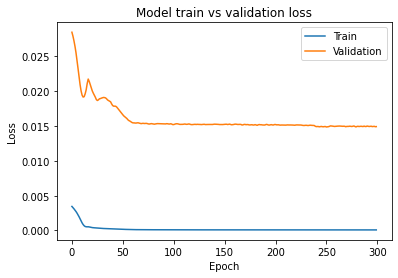

In [95]:
# OVERFITTING - val_loss >> train_loss
# just right would be val_loss ~ train_loss

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model train vs validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Model for fatal cases

In [96]:
n_features = X_fatalities.shape[2]
epochs = 300
batch_size = 38


model_fatalities = Sequential()
model_fatalities.add(LSTM(100, activation='relu', input_shape =(n_steps, n_features), return_sequences = True))
model_fatalities.add(LSTM(200, activation ='relu'))
model_fatalities.add(Dense(n_features, activation = 'relu'))

model_fatalities.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 3, 100)            114000    
_________________________________________________________________
lstm_22 (LSTM)               (None, 200)               240800    
_________________________________________________________________
dense_11 (Dense)             (None, 184)               36984     
Total params: 391,784
Trainable params: 391,784
Non-trainable params: 0
_________________________________________________________________


In [97]:

model_fatalities.compile(optimizer='adam', loss = 'msle', metrics = ['acc'])
#callbacks = [ReduceLROnPlateau(monitor='val_l|oss', patience = 5, verbose = 1, factor = 0.6),
 #            EarlyStopping(monitor='val_loss', patience = 20),
  #           ModelCheckpoint(filepath = 'best_model_confirmed.h5', monitor ='val_loss', save_best_only = True)]

# fit the model
hist = model_fatalities.fit(X_train_fatal, y_train_fatal, epochs = epochs,  
                    validation_split = 0.33)

Train on 48 samples, validate on 12 samples
Epoch 1/300
48/48 [==============================] - 1s 23ms/step - loss: 0.0017 - acc: 0.1250 - val_loss: 0.0131 - val_acc: 0.5833
Epoch 2/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 0.5833
Epoch 3/300
48/48 [==============================] - 0s 987us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.5833
Epoch 4/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0126 - val_acc: 0.5833
Epoch 5/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 0.5833
Epoch 6/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 0.5833
Epoch 7/300
48/48 [==============================] - 0s 1ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0117 - val_acc: 0.5833
Epoch 8/300
48/48 [=================

48/48 [==============================] - 0s 953us/step - loss: 5.4829e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.5833
Epoch 62/300
48/48 [==============================] - 0s 852us/step - loss: 5.3985e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.5833
Epoch 63/300
48/48 [==============================] - 0s 902us/step - loss: 5.2925e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.5833
Epoch 64/300
48/48 [==============================] - 0s 849us/step - loss: 5.2140e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.5833
Epoch 65/300
48/48 [==============================] - 0s 1ms/step - loss: 5.1094e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.5833
Epoch 66/300
48/48 [==============================] - 0s 992us/step - loss: 5.0191e-05 - acc: 1.0000 - val_loss: 0.0079 - val_acc: 0.5833
Epoch 67/300
48/48 [==============================] - 0s 920us/step - loss: 4.9359e-05 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 0.5833
Epoch 68/300
48/48 [=============================

48/48 [==============================] - 0s 921us/step - loss: 3.4537e-05 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.5833
Epoch 121/300
48/48 [==============================] - 0s 1ms/step - loss: 3.4353e-05 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.5833
Epoch 122/300
48/48 [==============================] - 0s 963us/step - loss: 3.4298e-05 - acc: 1.0000 - val_loss: 0.0076 - val_acc: 0.5833
Epoch 123/300
48/48 [==============================] - 0s 1ms/step - loss: 3.4309e-05 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.5833
Epoch 124/300
48/48 [==============================] - 0s 1ms/step - loss: 3.4103e-05 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.5833
Epoch 125/300
48/48 [==============================] - 0s 913us/step - loss: 3.4160e-05 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.5833
Epoch 126/300
48/48 [==============================] - 0s 965us/step - loss: 3.4026e-05 - acc: 1.0000 - val_loss: 0.0075 - val_acc: 0.5833
Epoch 127/300
48/48 [==========================

48/48 [==============================] - 0s 960us/step - loss: 3.1803e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 180/300
48/48 [==============================] - 0s 872us/step - loss: 3.1910e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 181/300
48/48 [==============================] - 0s 955us/step - loss: 3.2081e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 182/300
48/48 [==============================] - 0s 1ms/step - loss: 3.1807e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 183/300
48/48 [==============================] - 0s 979us/step - loss: 3.1765e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 184/300
48/48 [==============================] - 0s 1ms/step - loss: 3.1649e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 185/300
48/48 [==============================] - 0s 945us/step - loss: 3.1591e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 186/300
48/48 [========================

48/48 [==============================] - 0s 914us/step - loss: 2.9844e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.5833
Epoch 239/300
48/48 [==============================] - 0s 799us/step - loss: 2.9824e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.5833
Epoch 240/300
48/48 [==============================] - 0s 818us/step - loss: 2.9841e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.5833
Epoch 241/300
48/48 [==============================] - 0s 1ms/step - loss: 2.9838e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.5833
Epoch 242/300
48/48 [==============================] - 0s 990us/step - loss: 2.9836e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 243/300
48/48 [==============================] - 0s 921us/step - loss: 2.9881e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 244/300
48/48 [==============================] - 0s 1ms/step - loss: 2.9730e-05 - acc: 1.0000 - val_loss: 0.0074 - val_acc: 0.5833
Epoch 245/300
48/48 [========================

Epoch 297/300
48/48 [==============================] - 0s 996us/step - loss: 2.8404e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.5833
Epoch 298/300
48/48 [==============================] - 0s 978us/step - loss: 2.8375e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.5833
Epoch 299/300
48/48 [==============================] - 0s 845us/step - loss: 2.8280e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.5833
Epoch 300/300
48/48 [==============================] - 0s 922us/step - loss: 2.8288e-05 - acc: 1.0000 - val_loss: 0.0073 - val_acc: 0.5833


In [98]:
scores = model_fatalities.evaluate(X_train_fatal, y_train_fatal)
print("Model accuracy: %.2f"%(scores[1]*100),"%")

60/60 [==============================] - 0s 228us/step
Model accuracy: 91.67 %


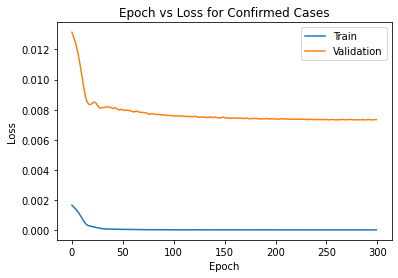

In [99]:
# OVERFITTING - val loss > train loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Epoch vs Loss for Confirmed Cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [57]:
#last_confirmed = list()
#last_confirmed.append(Confirmed[len(Confirmed)-n_steps_in:len(Confirmed)+1])
#last_confirmed = np.array(last_confirmed)
#print(last_confirmed.shape)


(1, 2, 180)


## Predicting confirmed cases

In [100]:
#trainPredict = model_confirmed.predict(X_train_confirmed)
testPredict = model_confirmed.predict(X_val_confirmed)

print(testPredict.shape)
testPredict = scaler_c.inverse_transform(testPredict)
y_val_confirmed = scaler_c.inverse_transform(y_val_confirmed)


(16, 184)


In [101]:
import datetime
from dateutil.relativedelta import relativedelta

res_ = dict()   
countries = train['Country_Region'].unique()
#len(countries)
dates = []
start_date = "2020-3-26"
date1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")
for i in range(len(testPredict)):
    res_[i] = testPredict[i]
    dates.append(date1.strftime("%Y-%m-%d"))
    date1 += relativedelta(days = 1)
    
res = pd.DataFrame(pd.DataFrame(pd.DataFrame(res_).values.T))
res.columns = countries

res['Date'] = dates
res = pd.pivot_table(res, index = 'Date')
print("Predicted test values: ")
res[11:]
res['Serbia']

Predicted test values: 


Date
2020-03-26    0.0
2020-03-27    0.0
2020-03-28    0.0
2020-03-29    0.0
2020-03-30    0.0
2020-03-31    0.0
2020-04-01    0.0
2020-04-02    0.0
2020-04-03    0.0
2020-04-04    0.0
2020-04-05    0.0
2020-04-06    0.0
2020-04-07    0.0
2020-04-08    0.0
2020-04-09    0.0
2020-04-10    0.0
Name: Serbia, dtype: float32

In [102]:
print("Real test values: ")

real = dict()   
for i in range(len(y_val_confirmed)):
    real[i] = y_val_confirmed[i]
 
    
real = pd.DataFrame(pd.DataFrame(pd.DataFrame(real).values.T))
real.columns = countries

real['Date'] = dates
real = pd.pivot_table(real, index = 'Date')
real[11:]
real['Serbia']

Real test values: 


Date
2020-03-26     384.000031
2020-03-27     384.000031
2020-03-28     457.000000
2020-03-29     659.000000
2020-03-30     741.000000
2020-03-31     785.000000
2020-04-01     899.999939
2020-04-02    1060.000000
2020-04-03    1171.000000
2020-04-04    1476.000000
2020-04-05    1624.000000
2020-04-06    1908.000000
2020-04-07    2200.000000
2020-04-08    2447.000000
2020-04-09    2666.000000
2020-04-10    2867.000000
Name: Serbia, dtype: float32

In [103]:
fig = go.Figure()

Serbia_predicted = res['Serbia']
Serbia_real = real['Serbia']

Serbia_predicted.values
fig.add_trace(go.Scatter(x = dates, y = Serbia_predicted.values, name = "Predicted cases"))
fig.add_trace(go.Scatter(x = dates, y = Serbia_real.values, name = "Realised cases"))
fig.update_layout(title = "Confirmed COVID-19 cases in Serbia",
                  xaxis_title = "Date",
                  yaxis_title = "Cases")
fig.layout.template = 'plotly_white'
fig.show()

## Predicting fatal cases

In [104]:
testPredict_f = model_fatalities.predict(X_val_fatal)

print(testPredict_f.shape)

testPredict_f = scaler_f.inverse_transform(testPredict_f)
y_val_fatal = scaler_f.inverse_transform(y_val_fatal)


(16, 184)


In [106]:
res_ = dict()   
countries = train['Country_Region'].unique()
dates = []
start_date = "2020-3-26"
date1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")
for i in range(len(testPredict_f)):
    res_[i] = testPredict_f[i]
    dates.append(date1.strftime("%Y-%m-%d"))
    date1 += relativedelta(days = 1)
    
res = pd.DataFrame(pd.DataFrame(pd.DataFrame(res_).values.T))
res.columns = countries

res['Date'] = dates
res = pd.pivot_table(res, index = 'Date')
print("Predicted test values: ")
res[11:]
res['Serbia']

Predicted test values: 


Date
2020-03-26    0.0
2020-03-27    0.0
2020-03-28    0.0
2020-03-29    0.0
2020-03-30    0.0
2020-03-31    0.0
2020-04-01    0.0
2020-04-02    0.0
2020-04-03    0.0
2020-04-04    0.0
2020-04-05    0.0
2020-04-06    0.0
2020-04-07    0.0
2020-04-08    0.0
2020-04-09    0.0
2020-04-10    0.0
Name: Serbia, dtype: float32

In [107]:
print("Real test values: ")

real = dict()   
for i in range(len(y_val_fatal)):
    real[i] = y_val_fatal[i]
 
    
real = pd.DataFrame(pd.DataFrame(pd.DataFrame(real).values.T))
real.columns = countries

real['Date'] = dates
real = pd.pivot_table(real, index = 'Date')
real[11:]
real['Serbia']

Real test values: 


Date
2020-03-26     4.000000
2020-03-27     1.000000
2020-03-28     1.000000
2020-03-29    10.000000
2020-03-30    13.000000
2020-03-31    16.000000
2020-04-01    16.000000
2020-04-02    28.000000
2020-04-03    31.000002
2020-04-04    39.000000
2020-04-05    44.000000
2020-04-06    51.000000
2020-04-07    57.999996
2020-04-08    61.000000
2020-04-09    65.000000
2020-04-10    66.000000
Name: Serbia, dtype: float32

In [108]:
fig = go.Figure()

Serbia_predicted = res['Serbia']
Serbia_real = real['Serbia']

Serbia_predicted.values
fig.add_trace(go.Scatter(x = dates, y = Serbia_predicted.values, name = "Predicted cases"))
fig.add_trace(go.Scatter(x = dates, y = Serbia_real.values, name = "Realized cases"))
fig.update_layout(title = "Fatal COVID-19 cases in Serbia",
                  xaxis_title = "Date",
                  yaxis_title = "Cases")
fig.layout.template = 'plotly_white'
fig.show()

<class 'pandas.core.frame.DataFrame'>
ISPIS
predicted=141.165737, expected=146.000000
predicted=168.460439, expected=174.000000
predicted=201.594521, expected=186.000000
predicted=204.568878, expected=197.000000
predicted=208.392108, expected=212.000000
predicted=226.484097, expected=223.000000
predicted=235.074224, expected=243.000000
predicted=260.943886, expected=259.000000
predicted=276.476352, expected=277.000000
predicted=294.740817, expected=304.000000
predicted=329.016159, expected=333.000000
predicted=362.033672, expected=361.000000
predicted=389.708428, expected=377.000000
predicted=395.802199, expected=383.000000
predicted=389.574565, expected=400.000000
predicted=415.634587, expected=409.000000
Test MSE: 8.013


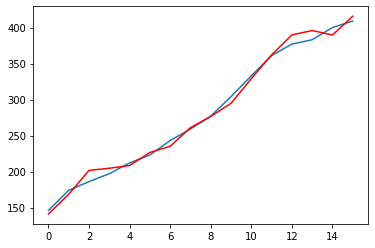

ISPIS
predicted=297.850821, expected=302.000000
predicted=340.091025, expected=367.000000
predicted=429.648011, expected=409.000000
predicted=457.547338, expected=454.000000
predicted=499.158480, expected=511.000000
predicted=566.339252, expected=584.000000
predicted=655.273543, expected=716.000000
predicted=848.665988, expected=847.000000
predicted=979.995810, expected=986.000000
predicted=1126.774678, expected=1171.000000
predicted=1358.384110, expected=1251.000000
predicted=1378.110800, expected=1320.000000
predicted=1391.799223, expected=1423.000000
predicted=1521.796057, expected=1468.000000
predicted=1528.039845, expected=1572.000000
predicted=1657.669470, expected=1666.000000
Test MSE: 41.902


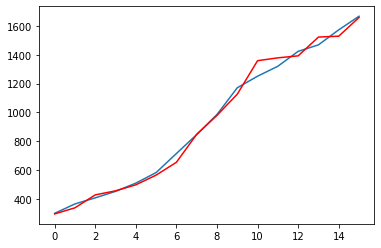

ISPIS
predicted=188.871267, expected=188.000000
predicted=217.087775, expected=224.000000
predicted=253.142308, expected=267.000000
predicted=306.849748, expected=308.000000
predicted=351.222795, expected=334.000000
predicted=369.466254, expected=370.000000
predicted=400.947068, expected=376.000000
predicted=401.616183, expected=390.000000
predicted=399.708139, expected=428.000000


/home/milena/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



predicted=454.117524, expected=439.000000
predicted=466.294091, expected=466.000000
predicted=484.112330, expected=501.000000
predicted=532.333836, expected=525.000000
predicted=555.669407, expected=545.000000
predicted=567.579909, expected=564.000000
predicted=583.926014, expected=583.000000
Test MSE: 13.209


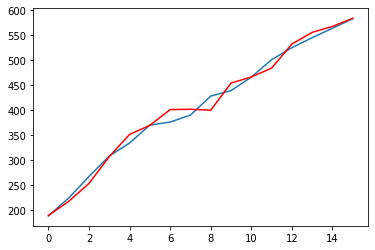

ISPIS
predicted=3.664564, expected=3.000000
predicted=3.000000, expected=4.000000
predicted=4.526201, expected=4.000000
predicted=4.599334, expected=5.000000
predicted=5.361549, expected=7.000000
predicted=8.610608, expected=7.000000
predicted=8.245326, expected=7.000000
predicted=7.000000, expected=8.000000
predicted=8.604434, expected=8.000000
predicted=8.461523, expected=8.000000
predicted=8.000000, expected=10.000000
predicted=11.186407, expected=14.000000
predicted=17.826537, expected=16.000000
predicted=18.594195, expected=17.000000
predicted=18.170558, expected=19.000000
predicted=20.845080, expected=19.000000
Test MSE: 1.418


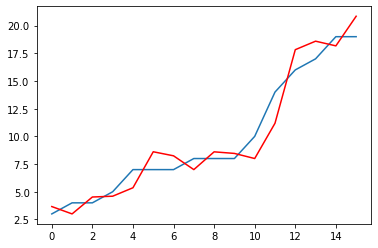

ISPIS
predicted=4.638629, expected=3.000000
predicted=3.000000, expected=7.000000
predicted=9.154658, expected=7.000000
predicted=10.188944, expected=7.000000
predicted=7.000000, expected=7.000000
predicted=7.000000, expected=7.000000
predicted=7.000000, expected=7.000000
predicted=7.000000, expected=7.000000
predicted=7.000000, expected=9.000000
predicted=10.044487, expected=15.000000
predicted=19.967539, expected=15.000000
predicted=18.567784, expected=15.000000
predicted=15.000000, expected=15.000000
predicted=15.000000, expected=19.000000
predicted=21.566885, expected=19.000000
predicted=20.859172, expected=19.000000
Test MSE: 2.801


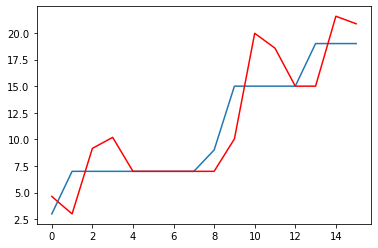

ISPIS
predicted=434.571397, expected=387.000000
predicted=467.052238, expected=502.000000


/home/milena/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning:

divide by zero encountered in true_divide



predicted=507.126598, expected=589.000000
predicted=700.272408, expected=690.000000
predicted=782.967608, expected=745.000000
predicted=837.521604, expected=820.000000
predicted=881.738392, expected=1054.000000
predicted=1187.622392, expected=1054.000000
predicted=1272.669930, expected=1133.000000
predicted=1159.666277, expected=1265.000000
predicted=1367.115019, expected=1451.000000
predicted=1609.410492, expected=1451.000000
predicted=1571.157493, expected=1554.000000
predicted=1594.687816, expected=1628.000000
predicted=1721.227537, expected=1715.000000
predicted=1795.957898, expected=1795.000000
Test MSE: 87.945


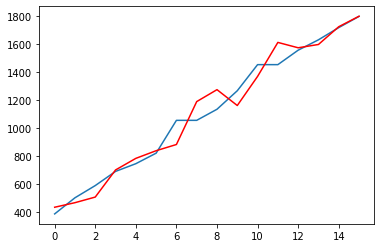

ISPIS
predicted=278.414405, expected=265.000000
predicted=280.553472, expected=290.000000
predicted=311.972295, expected=329.000000
predicted=364.079975, expected=407.000000
predicted=481.650134, expected=424.000000
predicted=480.362865, expected=482.000000
predicted=514.759318, expected=532.000000
predicted=587.800131, expected=571.000000
predicted=617.088818, expected=663.000000
predicted=724.563429, expected=736.000000
predicted=821.407605, expected=770.000000
predicted=823.687062, expected=822.000000
predicted=866.381933, expected=833.000000
predicted=865.555834, expected=853.000000
predicted=868.997455, expected=881.000000
predicted=905.687125, expected=921.000000
Test MSE: 28.330


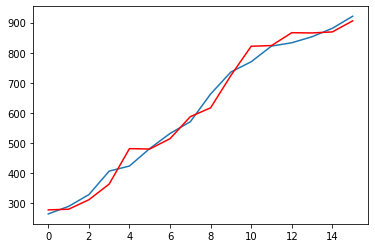

ISPIS
predicted=284.712980, expected=295.500000
predicted=339.245023, expected=351.250000
predicted=399.828287, expected=392.875000
predicted=443.535429, expected=455.000000
predicted=506.261897, expected=498.000000
predicted=554.284523, expected=545.125000
predicted=590.894767, expected=569.875000
predicted=609.000678, expected=607.750000
predicted=638.493414, expected=639.500000
predicted=675.713591, expected=666.250000
predicted=696.596784, expected=693.750000
predicted=721.415841, expected=710.875000
predicted=734.561018, expected=724.625000
predicted=740.622534, expected=736.875000
predicted=750.248290, expected=751.250000
predicted=764.699275, expected=763.500000
Test MSE: 9.222


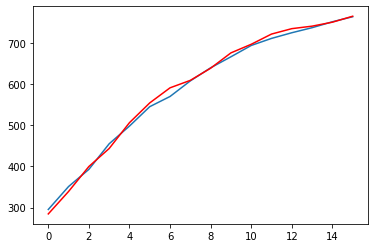

ISPIS
predicted=6095.856594, expected=5588.000000
predicted=5720.679341, expected=6909.000000
predicted=7375.421409, expected=7657.000000
predicted=8830.882318, expected=8271.000000
predicted=8970.299690, expected=8788.000000
predicted=9366.765676, expected=9618.000000
predicted=10301.840770, expected=10180.000000
predicted=10901.287748, expected=10711.000000
predicted=11269.886607, expected=11129.000000
predicted=11614.582880, expected=11524.000000
predicted=11939.232572, expected=11781.000000
predicted=12113.770943, expected=12051.000000
predicted=12320.022328, expected=12297.000000
predicted=12560.161963, expected=12639.000000
predicted=12939.266076, expected=12942.000000
predicted=13270.786016, expected=13244.000000
Test MSE: 377.052


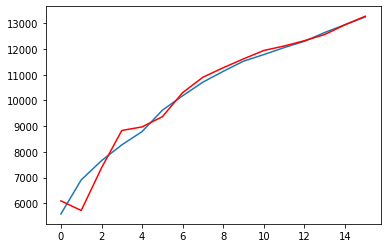

ISPIS
predicted=97.263115, expected=93.000000
predicted=105.276632, expected=122.000000
predicted=132.986815, expected=165.000000
predicted=204.162344, expected=182.000000
predicted=212.717785, expected=209.000000
predicted=231.891468, expected=273.000000
predicted=326.852382, expected=298.000000
predicted=346.164450, expected=359.000000
predicted=397.332065, expected=400.000000
predicted=455.117439, expected=443.000000
predicted=485.743770, expected=521.000000
predicted=579.308998, expected=584.000000
predicted=657.287064, expected=641.000000
predicted=702.588333, expected=717.000000
predicted=783.693365, expected=822.000000
predicted=914.705475, expected=926.000000
Test MSE: 22.363


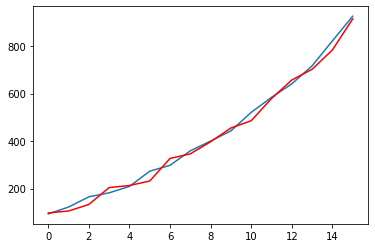

ISPIS
predicted=5.361912, expected=5.000000
predicted=5.692066, expected=9.000000
predicted=9.618514, expected=10.000000
predicted=13.525430, expected=10.000000
predicted=10.564222, expected=11.000000
predicted=11.449082, expected=14.000000
predicted=16.042632, expected=14.000000
predicted=15.798060, expected=21.000000
predicted=22.205809, expected=24.000000
predicted=30.046791, expected=24.000000
predicted=25.613286, expected=28.000000
predicted=29.719078, expected=28.000000
predicted=30.554146, expected=29.000000
predicted=29.421611, expected=33.000000
predicted=35.351762, expected=40.000000
predicted=45.648508, expected=41.000000
Test MSE: 3.245


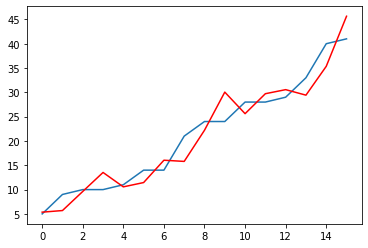

ISPIS
predicted=419.542070, expected=419.000000
predicted=441.415754, expected=458.000000
predicted=492.813969, expected=466.000000
predicted=487.838255, expected=476.000000
predicted=485.380234, expected=499.000000
predicted=517.061506, expected=515.000000
predicted=534.277189, expected=567.000000
predicted=604.534545, expected=569.000000
predicted=595.904977, expected=643.000000
predicted=675.216362, expected=672.000000
predicted=729.221240, expected=688.000000
predicted=711.462432, expected=700.000000
predicted=714.423562, expected=756.000000
predicted=789.084925, expected=811.000000
predicted=867.634398, expected=823.000000
predicted=857.336526, expected=887.000000
Test MSE: 28.282


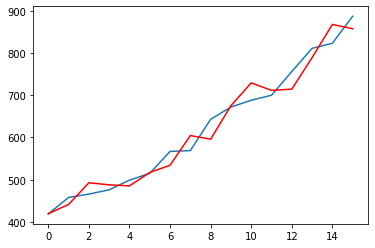

ISPIS
predicted=45.151681, expected=39.000000
predicted=42.094685, expected=44.000000
predicted=45.958137, expected=48.000000
predicted=52.648292, expected=48.000000
predicted=50.032686, expected=48.000000
predicted=48.000000, expected=49.000000
predicted=49.573140, expected=51.000000
predicted=52.604220, expected=54.000000
predicted=56.633967, expected=56.000000
predicted=58.473833, expected=61.000000
predicted=64.750103, expected=70.000000
predicted=77.781331, expected=88.000000
predicted=105.329858, expected=123.000000
predicted=167.124543, expected=164.000000
predicted=207.862099, expected=218.000000
predicted=279.134628, expected=330.000000
Test MSE: 14.202


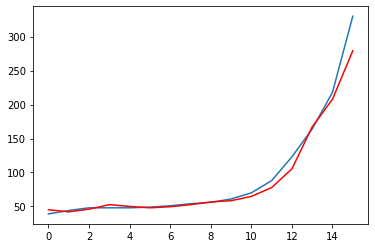

ISPIS
predicted=19.816831, expected=18.000000
predicted=18.361974, expected=18.000000
predicted=18.000000, expected=24.000000
predicted=27.988550, expected=26.000000
predicted=29.799849, expected=33.000000
predicted=37.566193, expected=33.000000
predicted=37.466598, expected=34.000000
predicted=34.488079, expected=34.000000
predicted=34.536632, expected=46.000000
predicted=51.330072, expected=51.000000
predicted=60.233410, expected=52.000000
predicted=54.829578, expected=56.000000
predicted=58.691980, expected=60.000000
predicted=64.078943, expected=63.000000
predicted=66.512597, expected=63.000000
predicted=64.337921, expected=66.000000
Test MSE: 4.369


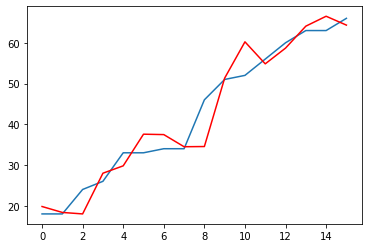

ISPIS
predicted=84.421404, expected=86.000000
predicted=87.691913, expected=86.000000
predicted=89.469874, expected=94.000000
predicted=96.558354, expected=94.000000
predicted=99.746894, expected=94.000000
predicted=94.000000, expected=152.000000
predicted=173.043468, expected=152.000000
predicted=202.654037, expected=163.000000
predicted=167.490318, expected=304.000000
predicted=392.009607, expected=351.000000
predicted=458.653834, expected=440.000000
predicted=506.477691, expected=562.000000
predicted=669.387985, expected=700.000000
predicted=832.891116, expected=861.000000
predicted=1014.078090, expected=1066.000000
predicted=1254.943648, expected=1486.000000
Test MSE: 73.740


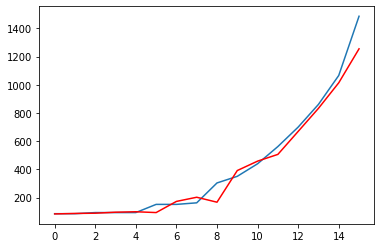

ISPIS
predicted=4733.727806, expected=4937.000000
predicted=5585.403782, expected=6235.000000
predicted=7634.618431, expected=7284.000000
predicted=8407.266249, expected=9134.000000
predicted=10631.412048, expected=10836.000000
predicted=12628.486844, expected=11899.000000
predicted=13157.041530, expected=12775.000000
predicted=13690.021300, expected=13964.000000
predicted=15122.616235, expected=15348.000000
predicted=16729.783273, expected=16770.000000
predicted=18209.869801, expected=18431.000000
predicted=20089.212010, expected=19691.000000
predicted=21036.705146, expected=20814.000000
predicted=21970.448971, expected=22194.000000
predicted=23560.067216, expected=23403.000000
predicted=24656.443325, expected=24983.000000
Test MSE: 387.312


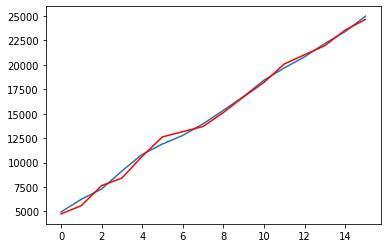

ISPIS
predicted=1.934386, expected=2.000000


/home/milena/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:220: RuntimeWarning:

divide by zero encountered in true_divide



predicted=2.078569, expected=2.000000
predicted=2.967249, expected=2.000000
predicted=2.000000, expected=2.000000
predicted=2.000000, expected=2.000000
predicted=2.000000, expected=3.000000
predicted=3.281327, expected=3.000000
predicted=3.797210, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=4.000000
predicted=4.359199, expected=4.000000
predicted=4.713366, expected=5.000000
predicted=5.276281, expected=7.000000
predicted=8.483803, expected=7.000000
predicted=8.394382, expected=8.000000
predicted=8.379590, expected=9.000000
Test MSE: 0.774


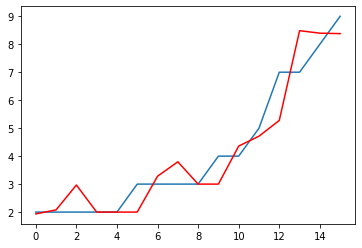

ISPIS
predicted=8.424279, expected=6.000000
predicted=6.411798, expected=6.000000
predicted=6.000000, expected=6.000000
predicted=6.000000, expected=6.000000
predicted=6.000000, expected=6.000000
predicted=6.000000, expected=6.000000
predicted=6.000000, expected=9.000000
predicted=10.903939, expected=13.000000
predicted=16.911690, expected=13.000000
predicted=14.142301, expected=16.000000
predicted=17.702396, expected=16.000000
predicted=17.640507, expected=22.000000
predicted=23.666408, expected=26.000000
predicted=31.303640, expected=26.000000
predicted=27.999209, expected=26.000000
predicted=26.000000, expected=26.000000
Test MSE: 2.471


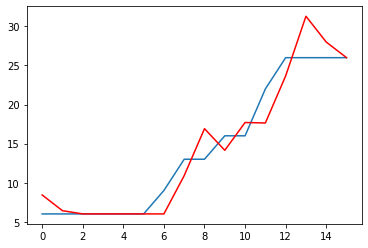

ISPIS
predicted=2.000000, expected=2.000000
predicted=2.000000, expected=2.000000
predicted=2.000000, expected=3.000000
predicted=3.525795, expected=3.000000
predicted=3.599339, expected=4.000000
predicted=4.361128, expected=4.000000
predicted=4.713338, expected=4.000000
predicted=4.000000, expected=4.000000
predicted=4.000000, expected=5.000000
predicted=5.399773, expected=5.000000
predicted=5.666227, expected=5.000000
predicted=5.000000, expected=5.000000
predicted=5.000000, expected=5.000000
predicted=5.000000, expected=5.000000
predicted=5.000000, expected=5.000000
predicted=5.000000, expected=5.000000
Test MSE: 0.480


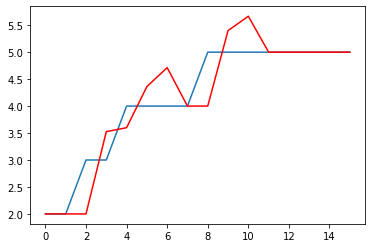

ISPIS
predicted=31.500740, expected=32.000000
predicted=34.613535, expected=43.000000
predicted=51.169354, expected=61.000000
predicted=79.614631, expected=74.000000
predicted=87.820786, expected=81.000000
predicted=87.969523, expected=97.000000
predicted=111.764349, expected=107.000000
predicted=118.880607, expected=115.000000
predicted=123.587963, expected=123.000000
predicted=131.139768, expected=132.000000
predicted=140.934953, expected=139.000000
predicted=146.567674, expected=157.000000
predicted=172.280322, expected=183.000000
predicted=208.899754, expected=194.000000
predicted=208.942351, expected=210.000000
predicted=224.918202, expected=264.000000
Test MSE: 12.103


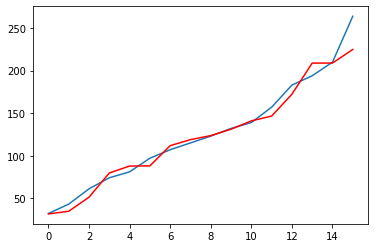

ISPIS
predicted=181.898443, expected=176.000000
predicted=202.095092, expected=191.000000
predicted=202.823096, expected=237.000000
predicted=263.781855, expected=258.000000
predicted=297.088395, expected=323.000000
predicted=353.240334, expected=368.000000
predicted=428.942121, expected=420.000000
predicted=468.332068, expected=459.000000
predicted=508.338692, expected=533.000000
predicted=582.157792, expected=579.000000
predicted=647.876609, expected=624.000000
predicted=670.771820, expected=654.000000
predicted=695.179859, expected=674.000000
predicted=701.089371, expected=764.000000
predicted=805.504607, expected=804.000000
predicted=881.389131, expected=858.000000
Test MSE: 23.506


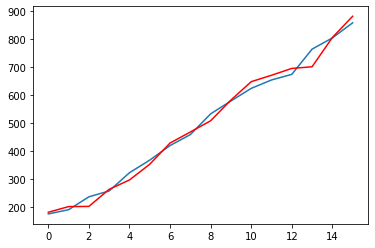

ISPIS


LinAlgError: Singular matrix

In [41]:
#arima_train.plot()
#arima_train.describe()
#arima_train

#ARIMA(p,d,q)
#We use plot_acf to identify parameter q for ARIMA
#plot_acf(arima_train)
# p -> 0  

#We use plot_pacf to identify p parameter
#plot_pacf(arima_train)
# p -> 1,2

def predictValuesARIMA(X):
    
    size = int(len(X) * 0.80)
    Atrain, Atest = X[0:size], X[size:len(X)]

    #In every iteration append predected value 

    history = [x for x in Atrain]
    predictions = list()

    for t in range(len(Atest)):
        model = ARIMA(history, order=(1,2,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = Atest[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))

    error = mean_squared_error(Atest, predictions)
    print('Test MSE: %.3f' % np.sqrt(error))
    # plot
    plt.plot(Atest)
    plt.plot(predictions, color='red')
    plt.show()
    return history
print(type(arima_train))

for i in range(1, len(arima_train.columns)):
    print("ISPIS")
    predictValuesARIMA(arima_train.iloc[:,i].values) 
